# Neccessary Import Statements

In [1]:
# Allows for changes made to scripts in src to be included in the work
# done in this notebook.
%load_ext autoreload
%autoreload 2

In [2]:
# file access
import os
import joblib
notebook_dir = os.getcwd()

In [3]:
# data manipulation
import pandas as pd
import dask.dataframe as dd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ML-related packages
from sklearn.model_selection import train_test_split

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt

# custom modules 
from src.data import common_tasks as ct
from src.data import feature_engineering as fe
from src.models import clustering as clus
from src.visualizations import basic_viz as bv

<Figure size 432x288 with 0 Axes>

# Add a Score Column to the Raw Tracking Data

In [4]:
full_df = ct.EVENTS_DF

In [5]:
full_df.tail()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
3251289,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
3251290,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
3251291,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
3251292,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234
3251293,10,Shot,"[{'id': 403}, {'id': 201}, {'id': 1216}, {'id'...",8005,"[{'y': 50, 'x': 86}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,2834.127168,100,251596236


### Following Code Actually Gets Column. Only Run If Data Is Not Already Saved

In [ ]:
scores_full_series = ct.score_compiler(events_data=full_df)
full_df["score"] = scores_full_series

In [ ]:
full_df.tail()

In [ ]:
### ONLY RUN CELL IF YOU WOULD LIKE TO SAVE THIS DATAFRAME ### 
score_rel_dir = "../data/interim"
score_dir = os.path.join(notebook_dir, score_rel_dir)

full_df.to_csv("{}/events_with_scores.csv".format(score_dir))

### Only run following scripts if the new dataframe with the score column has been saved

In [6]:
### ONLY RUN CELL IF YOU LIKE TO LOAD IN THIS DATAFRAME ###
score_rel_dir = "../data/interim"
score_dir = os.path.join(notebook_dir, score_rel_dir)

full_df = pd.read_csv(
    "{}/events_with_scores.csv".format(score_dir)
).drop(columns=["Unnamed: 0"])

In [7]:
full_df.tail()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score
3251289,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50.0,251596409,1-1
3251290,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30.0,251596232,1-1
3251291,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10.0,251596410,1-1
3251292,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10.0,251596234,1-1
3251293,10,Shot,"[{'id': 403}, {'id': 201}, {'id': 1216}, {'id'...",8005,"[{'y': 50, 'x': 86}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,2834.127168,100.0,251596236,1-1


# Join With Sequence Data

### First, load in that sequence data

In [ ]:
sequences_rel_dir = "../data/interim/compiled_sequences"
sequences_dir = os.path.join(notebook_dir, sequences_rel_dir)
sequences_dir

In [ ]:
sequence_files = [
    "{}/{}".format(sequences_dir, file) for file in os.listdir(sequences_dir)\
    if file.endswith(".h5")
]
sequences_df = pd.concat(
    [pd.read_hdf(seq_file, key="df") for seq_file in sequence_files], 
    ignore_index=True
)
sequences_df

Evidently, the assignment of a sequence ID (see `seq_id` column) did not go according to plan as we seperated the data into three different files. Thus, we will clean up that column here. We do this by taking advantage of the fact that each set piece sequence begins with a value for the `eventId` column of 3.

In [ ]:
indicies_of_sequence_starts = np.argwhere(
    (sequences_df.eventId == 3).to_numpy()
).flatten()
indicies_of_sequence_starts

In [ ]:
sp_sequence_ids_list = []
last_start = 0
current_id = 100
for index in indicies_of_sequence_starts:
    # First, update values for all of the events that make up the sequence
    # whose beginning row index we are now working with during this iteration.
    if last_start != index:
        sp_sequence_ids_list += [current_id]*(index-last_start)
    
        # Update necessary values
        current_id += 1
        last_start = index + 1
        
        sp_sequence_ids_list.append(current_id)
        assert len(sp_sequence_ids_list) == index + 1

# Fill in the values 
sp_sequence_ids_list += [current_id]*(
    sequences_df.shape[0]-len(sp_sequence_ids_list))

assert len(sp_sequence_ids_list) == sequences_df.shape[0]

In [ ]:
sequences_df.drop(columns="seq_id", inplace=True) 
sequences_df["seq_id"] = pd.Series(sp_sequence_ids_list)
sequences_df

### Now we are ready for the join

In [ ]:
# see https://stackoverflow.com/questions/40860457/improve-pandas-merge-performance
# for the trick we used to speed up this join.
sequences_with_scores_df = sequences_df.set_index("id").merge(
    right=full_df[["score", "id"]].set_index("id"), 
    how="left", 
    left_index=True, 
    right_index=True
).sort_values(by=["seq_id", "eventSec"]).reset_index(drop=False)

In [ ]:
sequences_with_scores_df.head(n=15)

In [ ]:
sequences_with_scores_df.tail(n=15)

# Compile Engineered Features

In [ ]:
features_df = fe.basic_instance_features(sequences_with_scores_df)

In [ ]:
features_df.head()

In [ ]:
### ONLY RUN THIS IF YOU ARE SAVING THIS DATAFRAME ###
features_rel_dir = "../data/final/initial_clustering"
feature_dir = os.path.join(notebook_dir, features_rel_dir)

features_df.to_csv("{}/init_clust_features.csv".format(feature_dir))

In [8]:
### ONLY RUN THIS IF YOU ARE LOADING THIS DATAFRAME ###
features_rel_dir = "../data/final/initial_clustering"
feature_dir = os.path.join(notebook_dir, features_rel_dir)

features_df = pd.read_csv(
    "{}/init_clust_features.csv".format(feature_dir)
).drop(columns=["Unnamed: 0"])
features_df

,seq_id,id,matchId,match_time,score_diff,is_goalie,is_mid,is_def,is_foward,pos_delta_diff,to_goal_delta_diff
0,100,198792553,2576040,1.410433,1,0,0,0,0,33.136083,-1.644629
1,100,198792554,2576040,1.411429,1,0,0,1,0,11.000000,4.030730
2,100,198792555,2576040,1.412065,1,0,0,1,0,31.953091,4.123299
3,100,198792556,2576040,1.412757,1,1,0,0,0,27.459060,0.164199
4,100,198792557,2576040,1.413324,1,0,0,1,0,18.439089,5.072621
...,...,...,...,...,...,...,...,...,...,...,...
1891129,275429,243183546,2501010,0.807815,1,0,0,1,0,34.000000,-9.711569
1891130,275429,243183126,2501010,0.808152,-1,0,0,1,0,4.472136,4.228152
1891131,275429,243183547,2501010,0.809438,1,0,0,0,0,106.282642,97.803399
1891132,275430,243183548,2501010,0.812060,1,0,0,0,1,46.324939,-37.916954


### Explore the Result

In [9]:
features_df.score_diff.value_counts()

 0    927804
-1    330594
 1    328775
 2    104265
-2    102308
 3     34925
-3     34850
-4      9947
 4      9283
-5      3520
 5      3351
-6       697
 6       622
-7        55
-8        50
 7        48
 8        40
Name: score_diff, dtype: int64

In [10]:
features_df.is_foward.value_counts()

0    1607056
1     284078
Name: is_foward, dtype: int64

In [11]:
features_df[["pos_delta_diff", "to_goal_delta_diff"]].describe()

,pos_delta_diff,to_goal_delta_diff
count,1.891134e+06,1.891134e+06
mean,2.610758e+01,-3.115176e+00
std,2.489531e+01,2.074108e+01
min,0.000000e+00,-1.068034e+02
25%,9.219544e+00,-1.181963e+01
50%,1.835756e+01,-2.284317e+00
75%,3.354102e+01,4.546684e+00
max,1.414214e+02,1.118034e+02


# Scale Engineered Features

In [12]:
features_not_to_scale_arr = features_df[
    ["match_time", "score_diff", "is_goalie", "is_mid", "is_def", "is_foward"]
].to_numpy()
features_not_to_scale_arr.shape

(1891134, 6)

In [13]:
features_not_to_scale_arr[0]

array([1.41043329, 1.        , 0.        , 0.        , 0.        ,
       0.        ])

In [14]:
features_to_scale_arr = features_df[
    ["pos_delta_diff", "to_goal_delta_diff"]
].to_numpy()
features_to_scale_arr.shape

(1891134, 2)

In [15]:
features_to_scale_arr[0]

array([33.13608305, -1.64462949])

In [16]:
std_scaler = StandardScaler()
scaled_features = std_scaler.fit_transform(X=features_to_scale_arr)
scaled_features.shape

(1891134, 2)

In [17]:
scaled_features[0]

array([0.28232236, 0.0709002 ])

In [18]:
print(scaled_features.mean(axis=0))
print(scaled_features.var(axis=0))

[ 1.05472990e-16 -3.50474511e-17]
[1. 1.]


In [19]:
full_scaled_feats_arr = np.hstack([features_not_to_scale_arr, scaled_features])
full_scaled_feats_arr.shape

(1891134, 8)

In [20]:
full_scaled_feats_arr[0]

array([1.41043329, 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.28232236, 0.0709002 ])

In [ ]:
full_unscaled_feats_arr = 

Thus, the order of the features going left-to-right in the columns is `match_time`, `score_diff`, `is_goalie`, `is_mid`, `is_def`, `is_foward`, `pos_delta_diff`, and `to_goal_delta_diff` with the latter two being scaled.

# Create Sequence-Wide Features

In [32]:
grouped_by_seq_df = features_df.groupby("seq_id")

In [38]:
aggregated_by_mean_df = grouped_by_seq_df.mean().drop(columns=["id", "matchId"])
aggregated_by_mean_df

,match_time,score_diff,is_goalie,is_mid,is_def,is_foward,pos_delta_diff,to_goal_delta_diff
seq_id,,,,,,,,
100,1.412520,0.714286,0.142857,0.142857,0.571429,0.000000,18.840974,1.656878
101,1.430684,-0.500000,0.000000,0.000000,0.500000,0.500000,8.475414,-5.379718
102,1.436421,-0.666667,0.000000,0.333333,0.666667,0.000000,25.822264,-4.729189
103,1.445103,0.777778,0.000000,0.555556,0.222222,0.111111,15.897360,-3.819662
104,1.450213,1.000000,0.000000,0.250000,0.250000,0.500000,43.733520,13.975425
...,...,...,...,...,...,...,...,...
275426,0.921815,0.111111,0.000000,0.333333,0.500000,0.111111,25.079667,-1.170050
275427,0.987549,1.000000,0.000000,0.200000,0.200000,0.600000,25.789828,-14.007084
275428,0.705332,0.000000,0.333333,0.666667,0.000000,0.000000,51.282563,6.192316


In [39]:
aggregated_by_mean_arr = aggregated_by_mean_df.to_numpy()
aggregated_by_mean_arr.shape

(275331, 8)

In [47]:
scaled = std_scaler.fit_transform(aggregated_by_mean_arr[:,[-2, -1]])
agg_by_mean_scaled_arr = np.hstack([aggregated_by_mean_arr.T[0:-2:].T,
                                   scaled])
agg_by_mean_scaled_arr.shape

(275331, 8)

In [49]:
print(scaled[0], end="\n\n\n")
print(agg_by_mean_scaled_arr[0])

[-0.61372447  0.46074248]


[ 1.41251981  0.71428571  0.14285714  0.14285714  0.57142857  0.
 -0.61372447  0.46074248]


# Fit Models

### K-means with scaled event-by-event data

In [21]:
training_X_scaled, test_X_scaled = train_test_split(full_scaled_feats_arr, 
                                                    test_size=0.2)

In [22]:
print(training_X_scaled.shape)
print(test_X_scaled.shape)

(1512907, 8)
(378227, 8)


In [ ]:
best_k_means_scaled = clus.kmeans_cluster(full_scaled_feats_arr)

In [ ]:
best_k_means_scaled

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_scaled, 
            "{}/best_k_means_scaled.sav".format(model_dir))

In [23]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_scaled = joblib.load(
    "{}/best_k_means_scaled.sav".format(model_dir)
)
best_k_means_scaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

### K-means with event-by-event un-scaled data

In [ ]:
best_k_means_unscaled = clus.kmeans_cluster(full_unscaled_feats_arr)

In [ ]:
best_k_means_unscaled

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_unscaled, 
            "{}/best_k_means_unscaled.sav".format(model_dir))

In [ ]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_unscaled = joblib.load(
    "{}/best_k_means_unscaled.sav".format(model_dir)
)
best_k_means_unscaled

### Mean-shift with event-by-event scaled data

### Mean-shift with event-by-event un-scaled data

### K-means with sequence-wide scaled data

In [50]:
best_k_means_agg_scaled = clus.kmeans_cluster(agg_by_mean_scaled_arr)

In [51]:
best_k_means_agg_scaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

In [52]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_agg_scaled, 
            "{}/best_k_means_agg_scaled.sav".format(model_dir))

['/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/notebooks/../models/initial_clustering/sequence_aggregation/best_k_means_agg_scaled.sav']

In [ ]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_agg_scaled = joblib.load(
    "{}/best_k_means_agg_scaled.sav".format(model_dir)
)
best_k_means_agg_scaled

### K-means with sequence-wide unscaled data

In [53]:
best_k_means_agg_unscaled = clus.kmeans_cluster(aggregated_by_mean_arr)

In [54]:
best_k_means_agg_unscaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

In [55]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_agg_unscaled, 
            "{}/best_k_means_agg_unscaled.sav".format(model_dir))

['/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/notebooks/../models/initial_clustering/sequence_aggregation/best_k_means_agg_unscaled.sav']

In [ ]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_agg_unscaled = joblib.load(
    "{}/best_k_means_agg_unscaled.sav".format(model_dir)
)
best_k_means_agg_unscaled

### Mean-shift with sequence-wide scaled data

In [ ]:
mean_shift_agg_scaled = clus.meanshift_cluster(agg_by_mean_scaled_arr)

In [ ]:
mean_shift_agg_scaled

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(mean_shift_agg_scaled, 
            "{}/mean_shift_agg_scaled.sav".format(model_dir))

In [ ]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

mean_shift_agg_scaled = joblib.load(
    "{}/mean_shift_agg_scaled.sav".format(model_dir)
)
mean_shift_agg_scaled

### Mean-shift with sequence-wide unscaled data

In [ ]:
mean_shift_agg_unscaled = clus.meanshift_cluster(aggregated_by_mean_arr)

In [ ]:
mean_shift_agg_unscaled

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(mean_shift_agg_unscaled, 
            "{}/mean_shift_agg_unscaled.sav".format(model_dir))

In [ ]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

mean_shift_agg_unscaled = joblib.load(
    "{}/mean_shift_agg_unscaled.sav".format(model_dir)
)
mean_shift_agg_unscaled

# Evaluate and Visualize Model Results

### Scaled Full Sequenece Data

In [24]:
scaled_prediction_arr = best_k_means_scaled.predict(full_scaled_feats_arr)

/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/src/visualizations/basic_viz.py:426: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


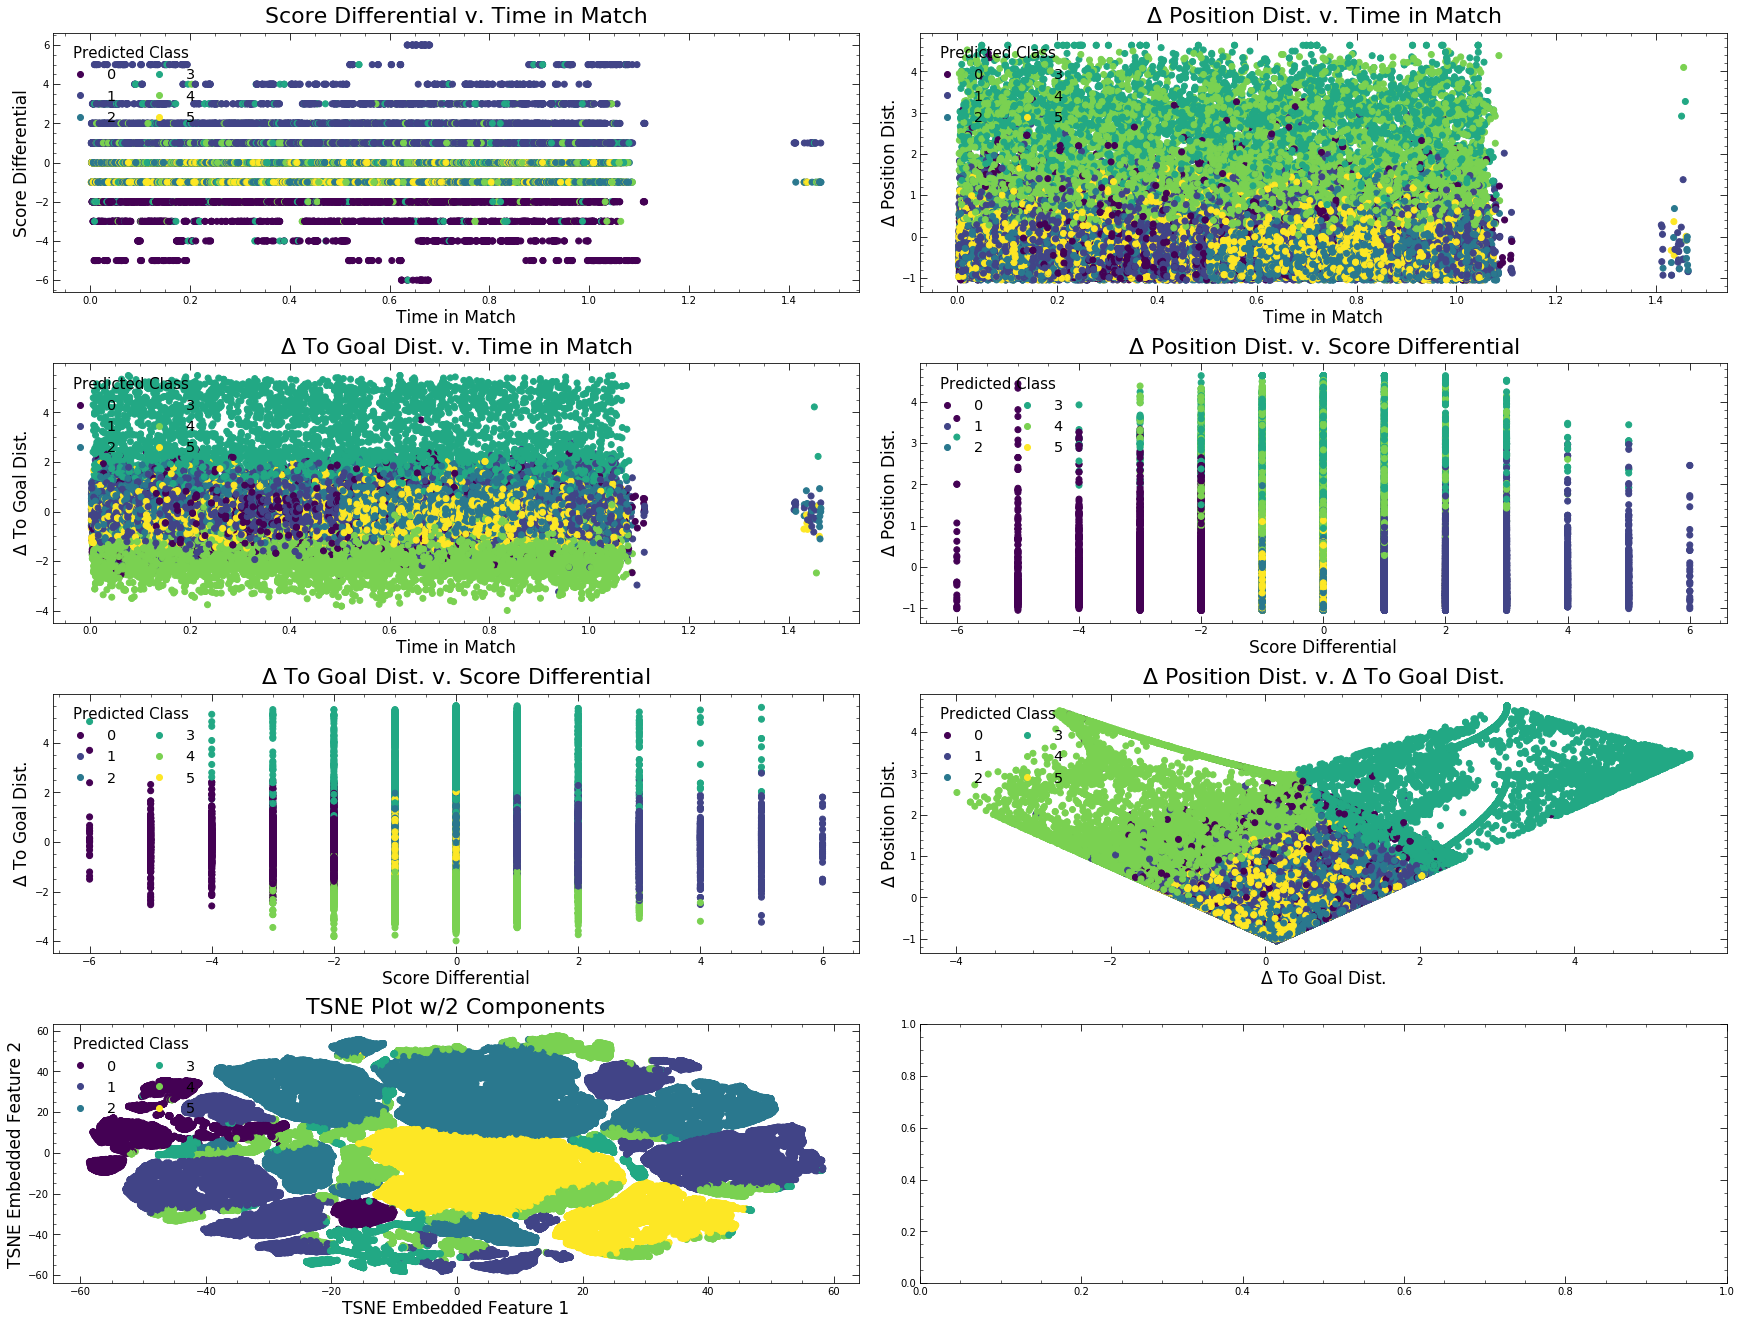

In [29]:
bv.cluster_subplot_generator(full_scaled_feats_arr[:100000:], 
                             scaled_prediction_arr[:100000:],
                             save_plot=True,
                             file_name="events_kmeans_scaled")

### Scaled Sequence-Wide K-Means

In [56]:
agg_scaled_k_means_predictions = best_k_means_agg_scaled.predict(agg_by_mean_scaled_arr)

/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/src/visualizations/basic_viz.py:426: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


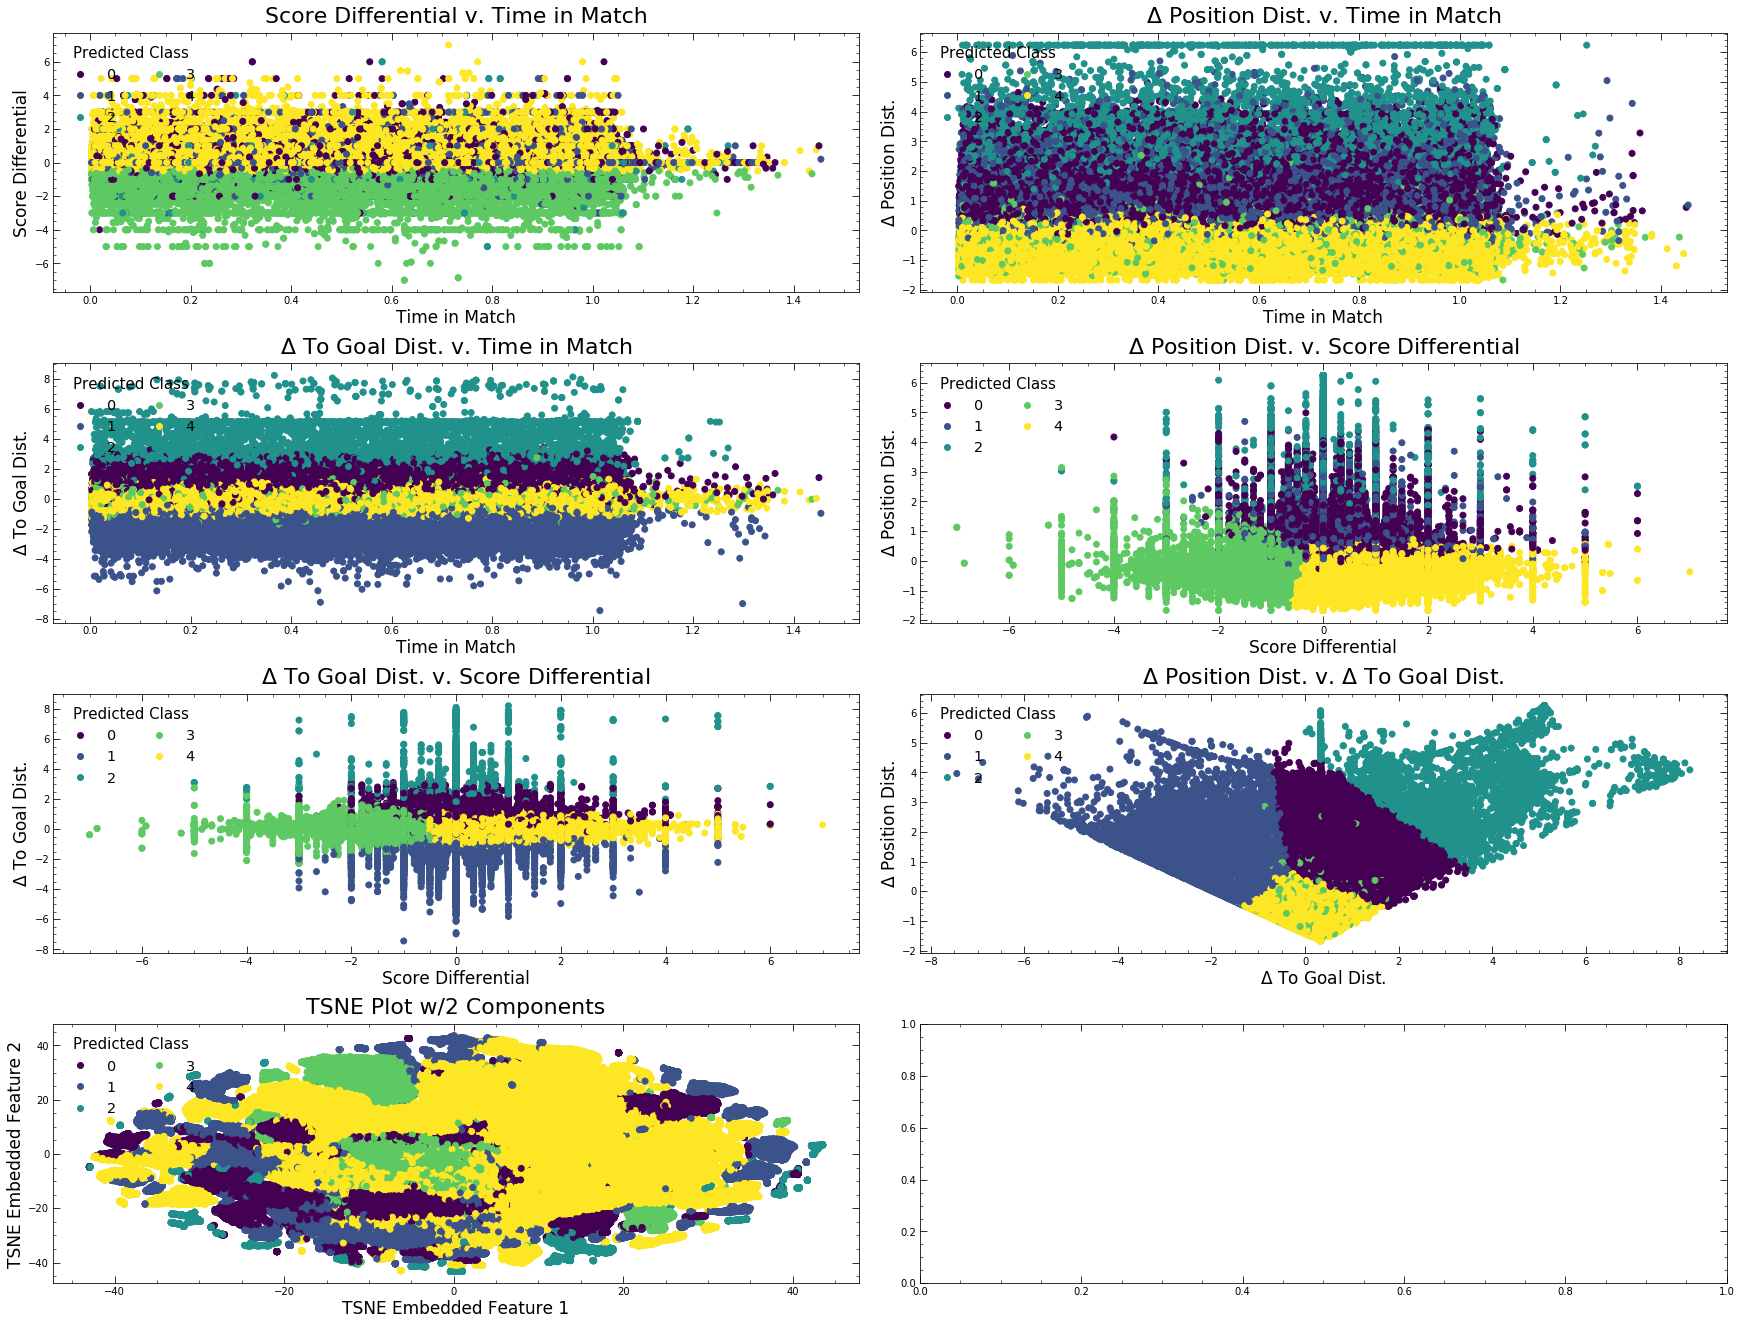

In [58]:
bv.cluster_subplot_generator(agg_by_mean_scaled_arr, 
                             agg_scaled_k_means_predictions,
                             save_plot=True,
                             file_name="seq_kmeans_scaled")

### Unscaled Sequenec-Wide K-Means

In [57]:
agg_unscaled_k_means_predictions = best_k_means_agg_unscaled.predict(aggregated_by_mean_arr)

/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/src/visualizations/basic_viz.py:426: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


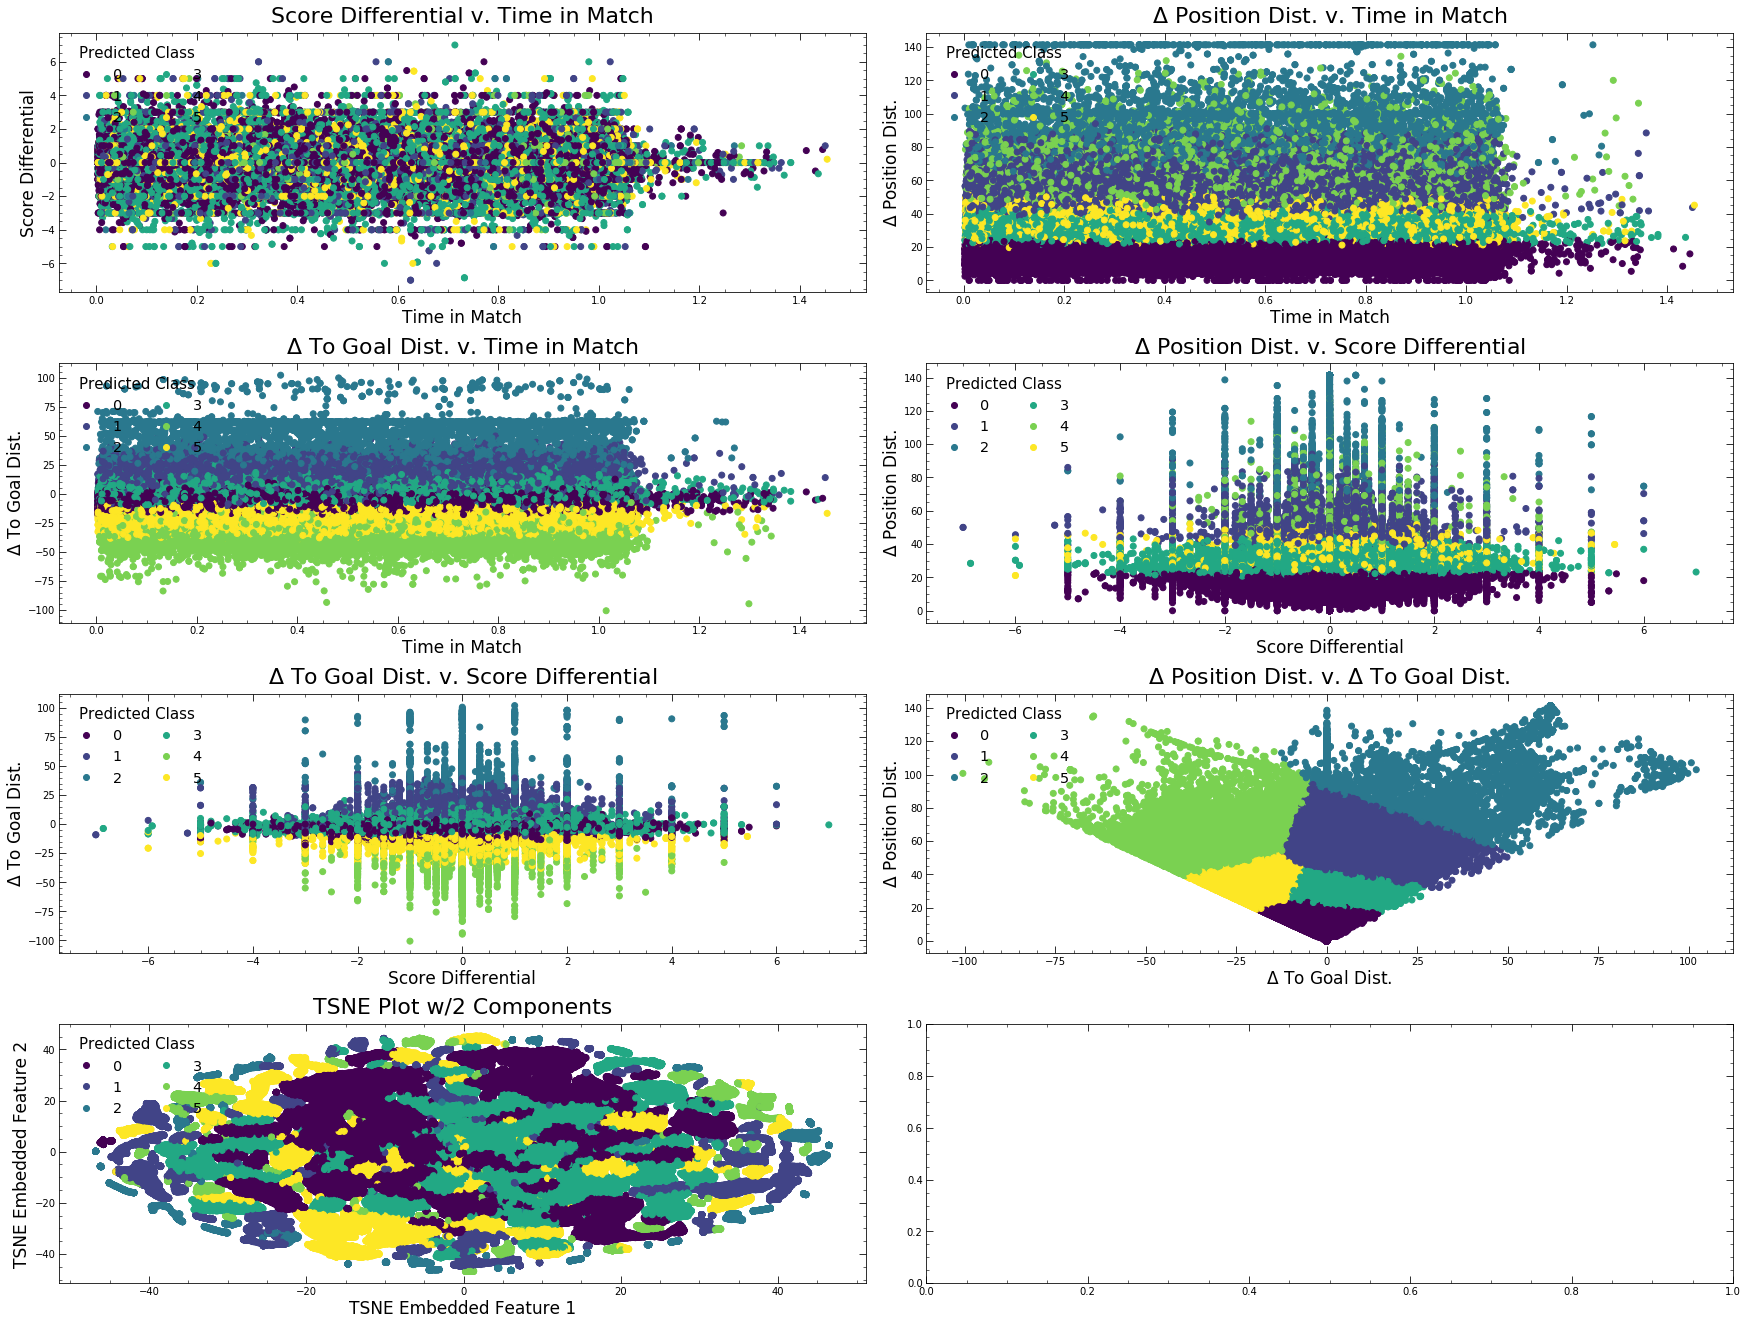

In [59]:
bv.cluster_subplot_generator(aggregated_by_mean_arr, 
                             agg_unscaled_k_means_predictions,
                             save_plot=True,
                             file_name="seq_kmeans_unscaled")

### Scaled Sequence-Wide Mean-Shift

In [ ]:
agg_scaled_mean_shift_predictions = mean_shift_agg_scaled.predict(agg_by_mean_scaled_arr)

In [ ]:
bv.cluster_subplot_generator(agg_by_mean_scaled_arr, 
                             agg_scaled_mean_shift_predictions,
                             save_plot=True,
                             file_name="seq_mean_shift_scaled")

### Unscaled Sequence-Wide Mean-Shift

In [ ]:
agg_unscaled_mean_shift_predictions = mean_shift_agg_unscaled.predict(aggregated_by_mean_arr)

In [ ]:
bv.cluster_subplot_generator(aggregated_by_mean_arr, 
                             agg_unscaled_mean_shift_predictions,
                             save_plot=True,
                             file_name="seq_mean_shift_unscaled")